## Imports

In [1]:
%run /kaggle/input/notebooks-fashion-mnist/Utils.ipynb import *
%run /kaggle/input/notebooks-fashion-mnist/Models.ipynb import *
from sklearn.model_selection import GridSearchCV

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Prepare Data

In [2]:
# load the data from keras datasets
fashion_mnist = tf.keras.datasets.fashion_mnist
# divide the data into train and test
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [3]:
data_processor = DataPreparator((X_train, X_test), (y_train, y_test))
# normalize train and test data
X_train, X_test = data_processor.normalize_data(value=255.0)
# add channel dimension for train and test data to be suitable for the CNN network
X_train, X_test = data_processor.reshape_data(axis=-1)
# encode train and test labels
y_train_encoded, y_test_encoded = data_processor.encode_labels()

## Training a CNN neural network

### LeNet-5 Training

In [4]:
# initialize the model and output the model summary
model = lenet_5()
lenet5 = model.create_model()
logs = TrainLogs(model= lenet5)
lenet5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 4, 4, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)               3

The mean accuracy of the model after 5 fold cross validation is: 0.9322478313446045
The mean validation accuracy of the model after 5 fold cross validation is: 0.9107733325958252
The mean loss of the model after 5 fold cross validation is: 0.183550895601511
The mean validation loss of the model after 5 fold cross validation is: 0.2500164548754692


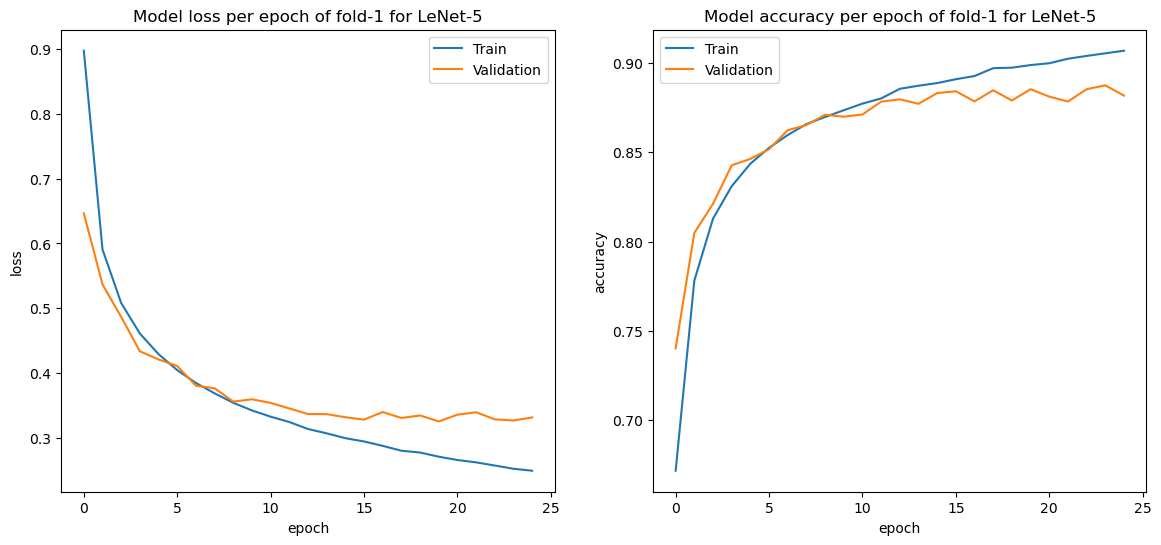

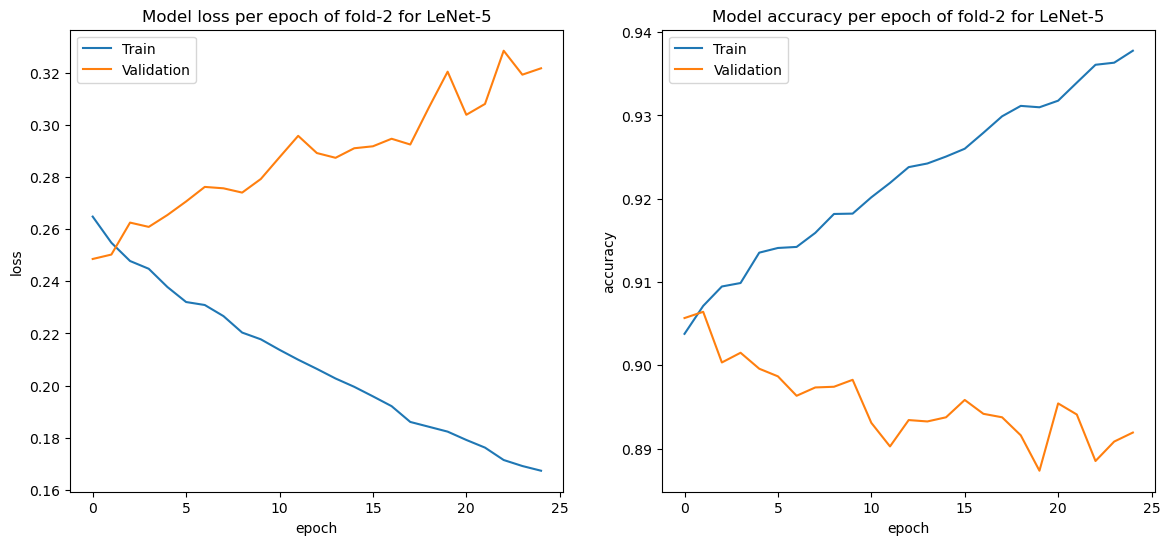

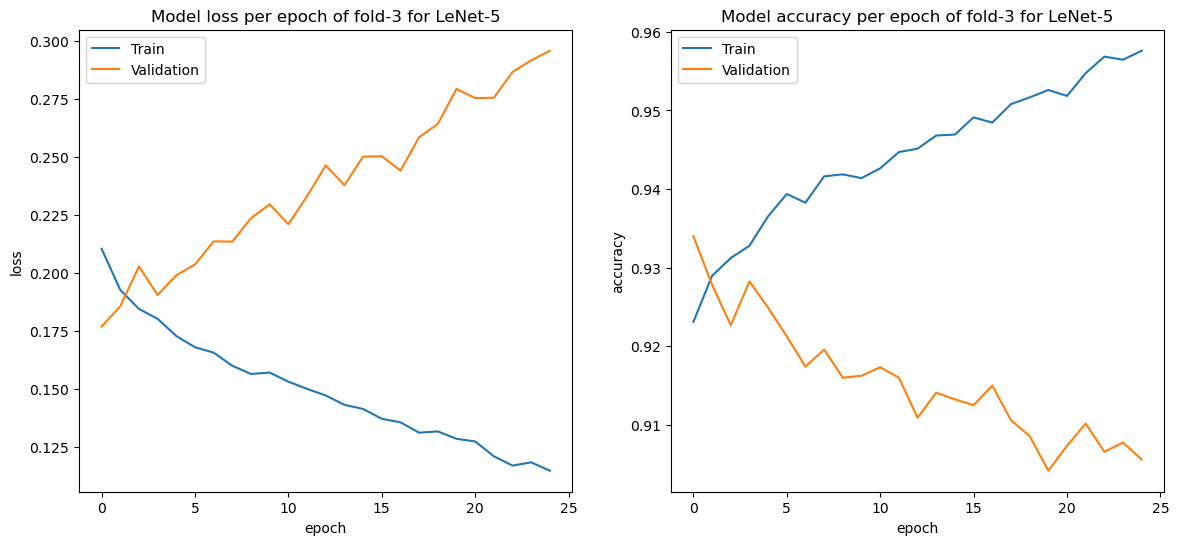

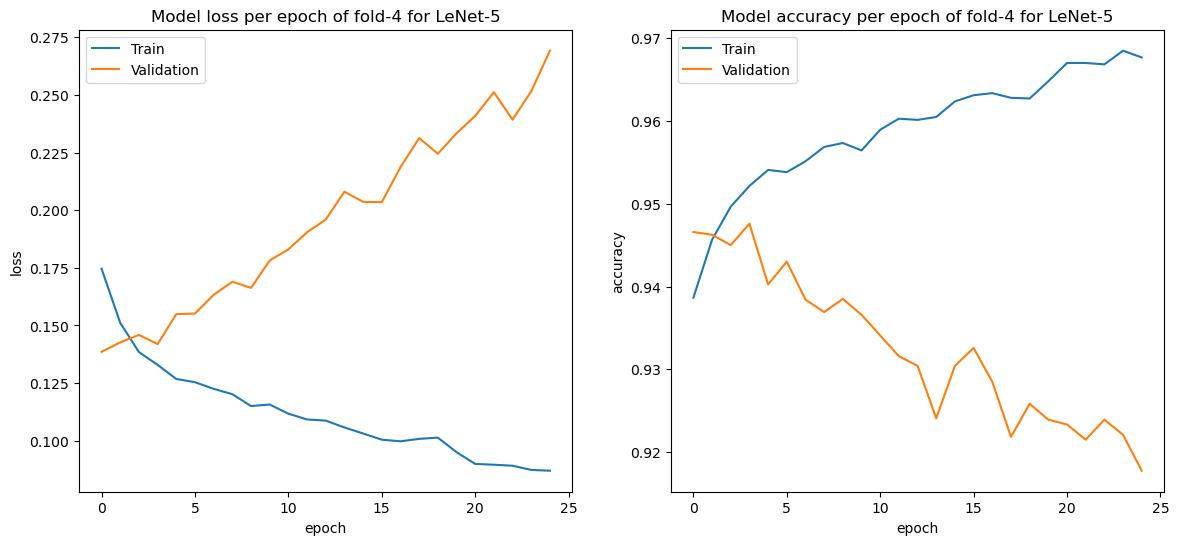

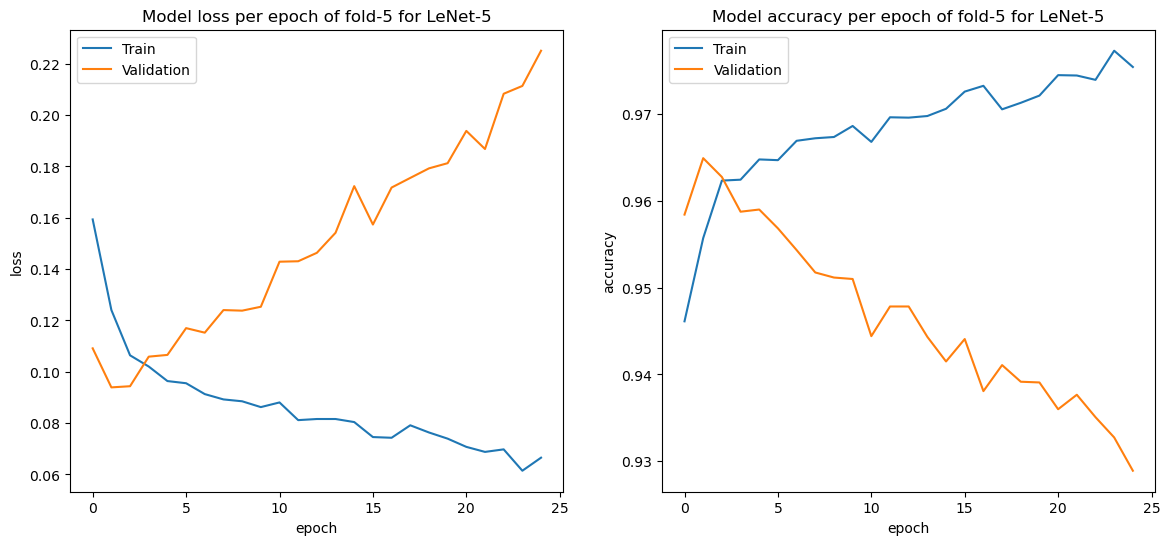

In [5]:
# perform 5 fold cross validation on the LeNet-5 model and visualize the results
histories, mean_accuracy, mean_validation_accuracy, mean_loss, mean_validation_loss = logs.k_fold_cross_validation(X_train, y_train, 5)
logs.cross_validation_report(histories, mean_accuracy, mean_validation_accuracy, mean_loss, mean_validation_loss, 5, ' for LeNet-5')

### Modify the Hyperparameters of LeNet-5 Architecture

Hyperparameters we can adjust for the **LeNet-5 Architecture** without editing any hyperparameters of the network are:
1. Batch size
2. Optimizer 
3. Learning Rate
4. Momentum

We will explore best combination of these hyperparameters by using **GridSearchCV**

In [4]:
def model_grid(batch_size, optimizer, learning_rate, momentum):
    if optimizer == Adam:
        lenet5 = lenet_5()
        model = lenet5.create_model(optimizer= optimizer(learning_rate= learning_rate))
    else:
        lenet5 = lenet_5()
        model = lenet5.create_model(optimizer= optimizer(learning_rate= learning_rate, momentum= momentum))
    return model

params = {
    'batch_size': [128, 512, 1024],
    'optimizer': [SGD, RMSprop],
    'learning_rate': [0.0001, 0.0003, 0.001],
    'momentum': [0.95, 0.97]
}
# making keras classifier
clf = KerasClassifier(build_fn= model_grid)
# start searching the hyperparameters
grid_search = GridSearchCV(estimator=clf, param_grid= params, verbose= 0)
grid_search.fit(X_train, y_train_encoded)

/tmp/ipykernel_28/4028750490.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasClassifier(build_fn= model_grid)


469/469 [==============================] - 4s 6ms/step - loss: 0.6044 - accuracy: 0.7821


GridSearchCV(estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f0679453820>,
             param_grid={'batch_size': [128, 512, 1024],
                         'learning_rate': [0.0001, 0.0003, 0.001],
                         'momentum': [0.95, 0.97],
                         'optimizer': [<class 'keras.optimizers.sgd.SGD'>,
                                       <class 'keras.optimizers.rmsprop.RMSprop'>]})

In [5]:
print('The Best score of applying GridSearchCV is:', grid_search.best_score_ , 'and this is for the following best hyperparameters:', grid_search.best_params_)

The Best score of applying GridSearchCV is: 0.8338333368301392 and this is for the following best hyperparameters: {'batch_size': 128, 'learning_rate': 0.0003, 'momentum': 0.95, 'optimizer': <class 'keras.optimizers.rmsprop.RMSprop'>}


After performing GridSearchCV, the best hyperparameters to be used in the model are:
1. batch_size =  128
2. learning_rate = 0.0003
3. momentum = 0.95 
4. optimizer = RMSprop

In [6]:
# hyperparameters
OPTIMIZER = RMSprop(learning_rate= 0.0003, momentum = 0.95)
BATCH_SIZE = 128
# define the model
tuned_lenet5 = lenet_5()
tuned_model = tuned_lenet5.create_model(OPTIMIZER)
logs = TrainLogs(model= tuned_model)
tuned_model.summary()

Model: "sequential_181"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_362 (Conv2D)         (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d_362 (Aver  (None, 12, 12, 6)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_363 (Conv2D)         (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_363 (Aver  (None, 4, 4, 16)         0         
 agePooling2D)                                                   
                                                                 
 flatten_181 (Flatten)       (None, 256)               0         
                                                                 
 dense_543 (Dense)           (None, 120)            

The mean accuracy of the model after 5 fold cross validation is: 0.9068266677856446
The mean validation accuracy of the model after 5 fold cross validation is: 0.8907113313674927
The mean loss of the model after 5 fold cross validation is: 0.2750436601638794
The mean validation loss of the model after 5 fold cross validation is: 0.37724816250801085


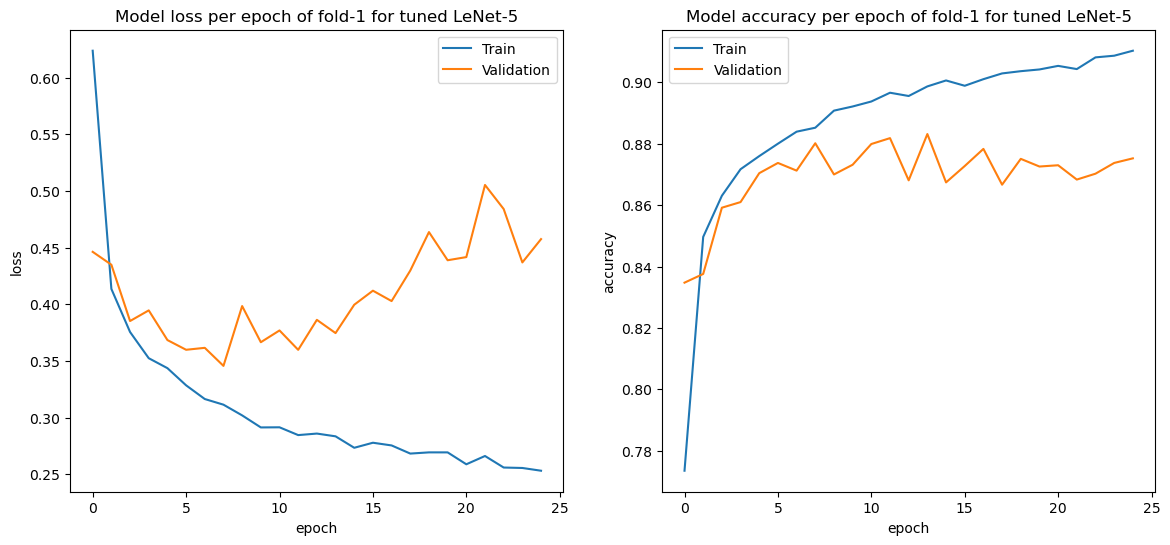

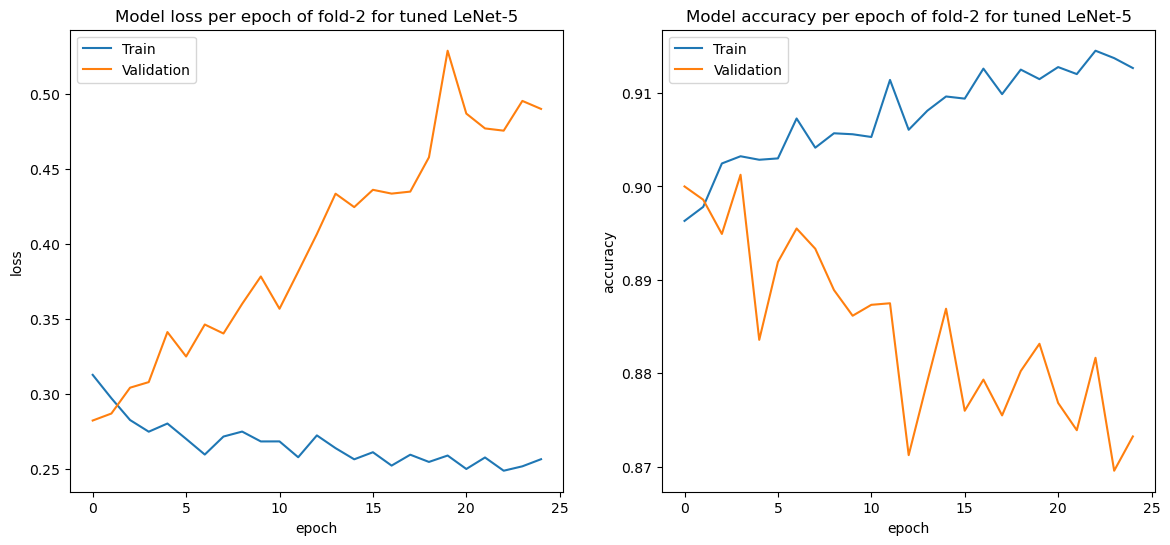

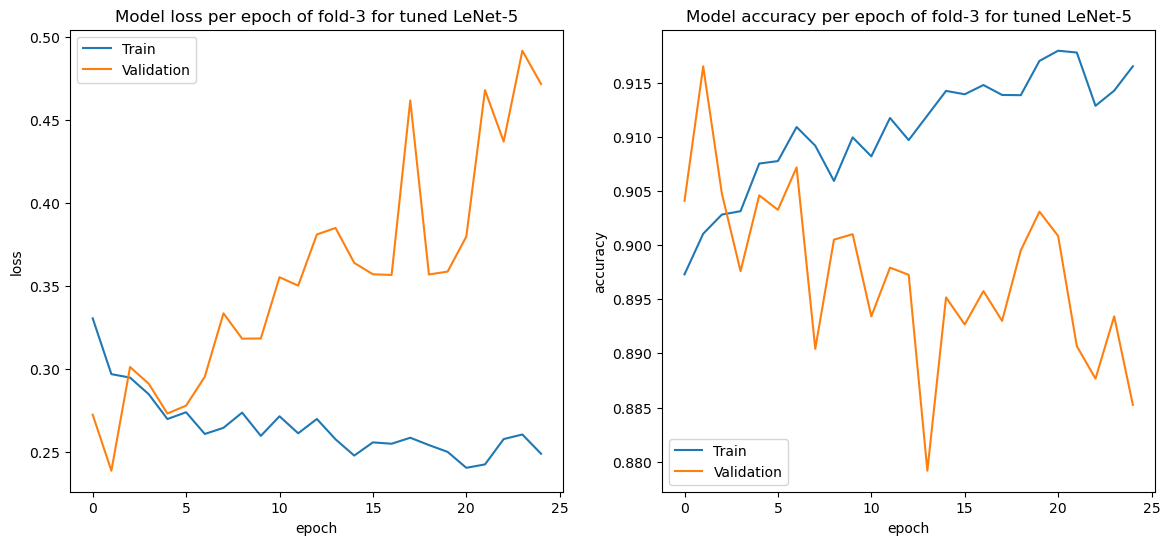

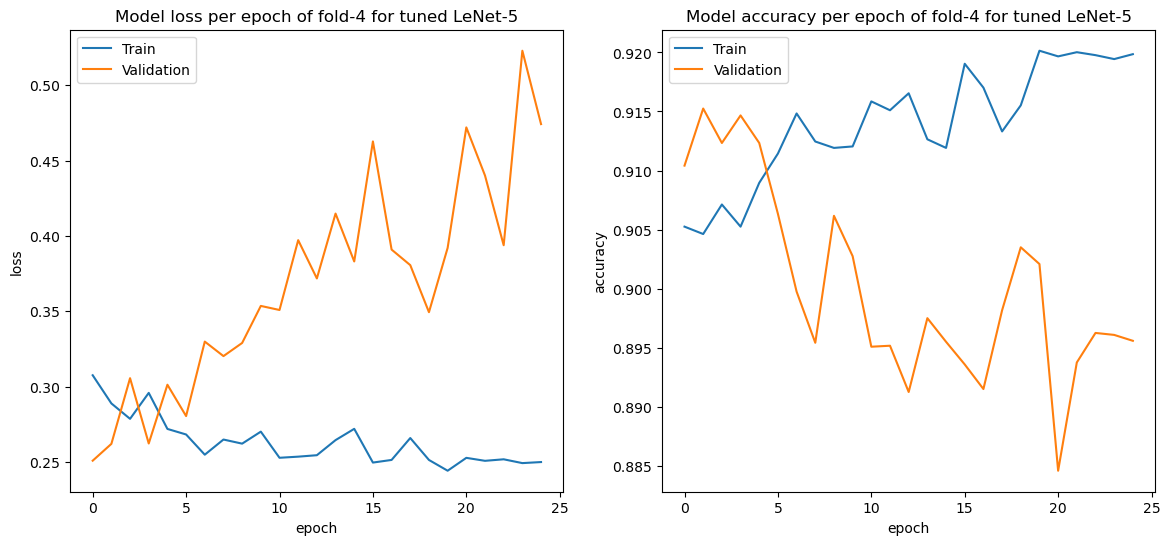

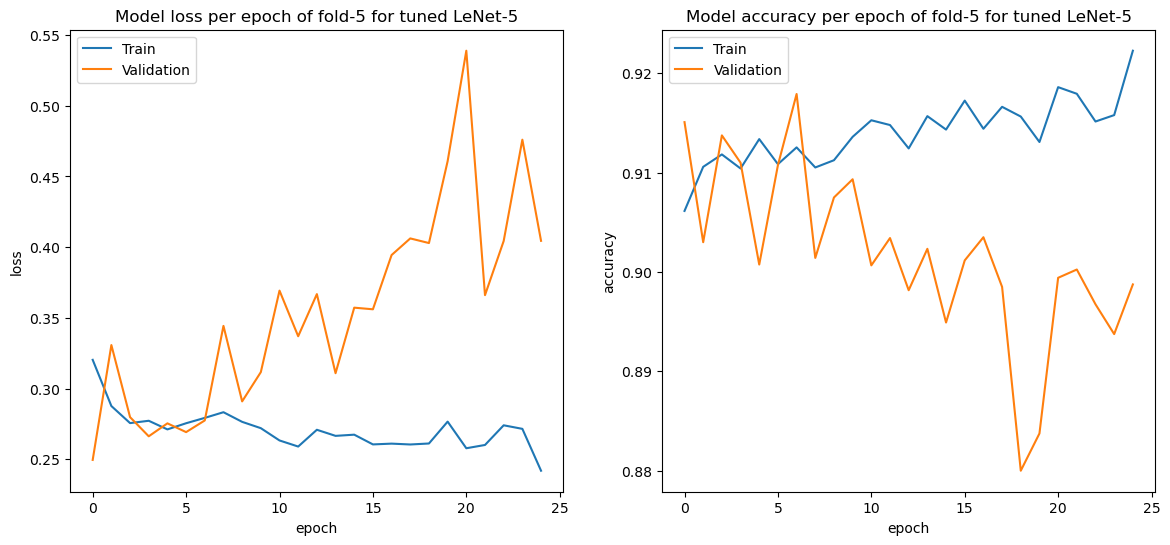

In [7]:
# perform 5 fold cross validation on the tuned LeNet-5 model and visualize the results
histories, mean_accuracy, mean_validation_accuracy, mean_loss, mean_validation_loss = logs.k_fold_cross_validation(X_train, y_train, 5, BATCH_SIZE, tuned_model)
logs.cross_validation_report(histories, mean_accuracy, mean_validation_accuracy, mean_loss, mean_validation_loss, 5, ' for tuned LeNet-5')

So from K-fold cross validation we see that after modifying some hyperparameter using GridSearchCV and used the best of them, the tuned model give us higher mean accuracy and less mean loss than the original LeNet-5 model, so the tuned model will be the model that we will be using it and evaluate it on test data, before evaluating on test data we will make final training for the tuned model

In [8]:
# final training for the tuned LeNet-5 model
history = tuned_model.fit(x= X_train, y= y_train_encoded, batch_size= BATCH_SIZE, validation_split = 0.1, epochs = 25)

Epoch 1/25
422/422 [==============================] - 3s 5ms/step - loss: 0.3219 - accuracy: 0.9087 - val_loss: 0.3450 - val_accuracy: 0.9057
Epoch 2/25
422/422 [==============================] - 2s 5ms/step - loss: 0.2859 - accuracy: 0.9135 - val_loss: 0.3158 - val_accuracy: 0.9105
Epoch 3/25
422/422 [==============================] - 2s 5ms/step - loss: 0.2924 - accuracy: 0.9122 - val_loss: 0.3192 - val_accuracy: 0.9000
Epoch 4/25
422/422 [==============================] - 2s 5ms/step - loss: 0.2707 - accuracy: 0.9147 - val_loss: 0.2933 - val_accuracy: 0.9072
Epoch 5/25
422/422 [==============================] - 2s 5ms/step - loss: 0.2615 - accuracy: 0.9161 - val_loss: 0.3333 - val_accuracy: 0.9077
Epoch 6/25
422/422 [==============================] - 2s 5ms/step - loss: 0.2714 - accuracy: 0.9154 - val_loss: 0.4679 - val_accuracy: 0.8777
Epoch 7/25
422/422 [==============================] - 2s 5ms/step - loss: 0.2774 - accuracy: 0.9124 - val_loss: 0.4298 - val_accuracy: 0.8908
Epoch 

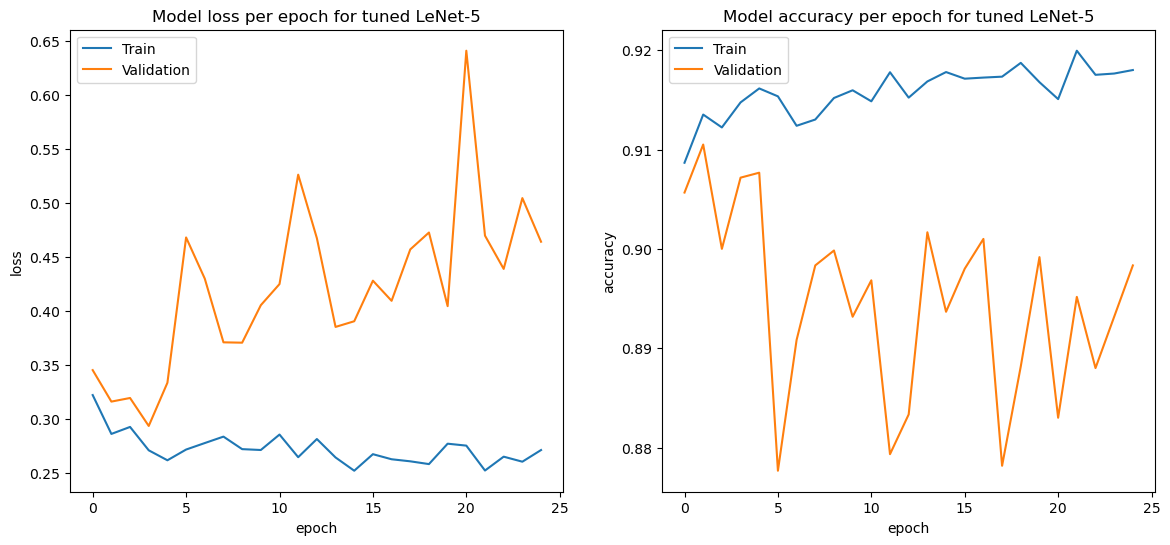

In [9]:
# visualize accuracy and loss curves of tuned LeNet-5 model
logs.train_curves(history, 'for tuned LeNet-5')

In [10]:
# evaluation of the tuned LeNet-5 model on the test data
loss, accuracy = tuned_model.evaluate(x= X_test,y= y_test_encoded, batch_size= BATCH_SIZE)
print('The loss of the tuned LeNet-5 model on test data is:', loss, 'and the accuracy is:', accuracy)

79/79 [==============================] - 0s 4ms/step - loss: 0.8727 - accuracy: 0.8665
The loss of the tuned LeNet-5 model on test data is: 0.8727008700370789 and the accuracy is: 0.8665000200271606
